In [1]:
# Core NLP / ML requirements
!pip install datasets transformers accelerate peft torch matplotlib seaborn scikit-learn textstat nltk pandas numpy
!pip install bitsandbytes
!pip install requests

# Japanese tokenization requirements (must be BEFORE you load Japanese models!)
!pip install fugashi ipadic unidic-lite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: nvidia-nvji

In [3]:
### Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re, torch, gc, random, os, requests
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import (
    AutoTokenizer, AutoModel,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType

warnings.filterwarnings('ignore')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
### Utility Functions for ABSA and Japanese Sentiment Dictionaries
import yaml
import json
import pandas as pd
import re
import os
import requests

def load_aspects_from_yaml(yaml_path):
    """Load aspects dictionary from YAML file."""
    with open(yaml_path, encoding="utf-8") as f:
        return yaml.safe_load(f)

def load_aspects_from_json(json_path):
    """Load aspects dictionary from JSON file."""
    with open(json_path, encoding="utf-8") as f:
        return json.load(f)

def load_aspects_from_csv(csv_path, aspect_col="aspect", keywords_col="keywords"):
    """
    Expects a CSV with one aspect per row, and keywords as a comma-separated string.
    Returns: dict { aspect: [keyword1, keyword2, ...], ... }
    """
    df = pd.read_csv(csv_path)
    aspects = {}
    for _, row in df.iterrows():
        aspect = str(row[aspect_col])
        keywords = [kw.strip() for kw in str(row[keywords_col]).split(',') if kw.strip()]
        aspects[aspect] = keywords
    return aspects

def extract_aspect_keywords_from_column(df, aspect_col="aspect", text_col="review_text", min_freq=2):
    """
    Automatically build aspect keyword dictionary from an annotated dataset column.
    For each aspect, finds most frequent words in `text_col` where `aspect_col`==aspect.
    Uses \w+ for basic tokenization. For Japanese, replace with MeCab if needed.
    """
    aspect_keywords = {}
    if aspect_col not in df.columns:
        print(f"Warning: aspect column '{aspect_col}' not in DataFrame.")
        return {}
    aspect_terms = df[aspect_col].dropna().unique().tolist()
    for aspect in aspect_terms:
        texts = df[df[aspect_col] == aspect][text_col].dropna()
        words = []
        for review in texts:
            # For Japanese, you may wish to tokenize more carefully.
            words += re.findall(r'\w+', str(review))
        freq = pd.Series(words).value_counts()
        # Most common (not aspect itself, and at least min_freq)
        keywords = [w for w, c in freq.items() if w != aspect and c >= min_freq][:10]
        if keywords:
            aspect_keywords[aspect] = keywords
        else:
            aspect_keywords[aspect] = [aspect]
    return aspect_keywords

import requests

import requests

def load_japanese_sentiment_dict(path_or_url):
    """
    Loads Negapoji Japanese sentiment words from local file or URL.
    Supports both (word, label) and (polarity, category, word) formats.
    Returns: dict { "positive": [...], "negative": [...] }
    """
    if path_or_url.startswith("http"):
        response = requests.get(path_or_url)
        response.raise_for_status()
        lines = response.text.splitlines()
    else:
        with open(path_or_url, encoding="utf-8") as f:
            lines = f.readlines()
    pos_words, neg_words = [], []
    for line in lines:
        if line.startswith("#") or not line.strip():
            continue
        # Try splitting by comma for the Wago file (-1,（経験）,引っ掛かる)
        cols = line.strip().split(",")
        if len(cols) >= 3:
            polarity = cols[0].strip()
            word = cols[2].strip()
            if polarity == "1":
                pos_words.append(word)
            elif polarity == "-1":
                neg_words.append(word)
        # If not, try tab for older Negapoji format
        else:
            cols = line.strip().split("\t")
            if len(cols) >= 2:
                word, label = cols[0].strip(), cols[1].strip()
                if label == "ポジ":
                    pos_words.append(word)
                elif label == "ネガ":
                    neg_words.append(word)
    return {"positive": pos_words, "negative": neg_words}



In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

class BusinessInsightExtractor:
    def __init__(self, aspects=None, label_map=None):
        """
        Args:
            aspects: dict, or None. If None, uses default hardcoded aspects.
            label_map: Optional, dict to map integer sentiment labels to string names
        """
        if aspects is not None:
            self.aspects = aspects
            print(f"Loaded {len(aspects)} aspects from config/data.")
        else:
            # Default aspects can be any language, e.g., Japanese beauty business
            self.aspects = {
                'quality': ['品質', '質', '良い', '悪い', '高品質', '低品質', 'クオリティ'],
                'service': ['サービス', '対応', '接客', '親切', '丁寧', '態度'],
                'price': ['価格', '値段', '料金', '安い', '高い', 'コスト', '費用'],
                'convenience': ['便利', '不便', '簡単', '難しい', '使いやすい', '使いにくい'],
                'speed': ['速い', '遅い', '早い', 'スピード', '迅速', '時間'],
                'atmosphere': ['雰囲気', '環境', '空間', '居心地', '快適', '不快']
            }
        self.label_map = label_map or {0: "negative", 1: "neutral", 2: "positive"}

    @classmethod
    def from_yaml(cls, yaml_path):
        return cls(load_aspects_from_yaml(yaml_path))

    @classmethod
    def from_json(cls, json_path):
        return cls(load_aspects_from_json(json_path))

    @classmethod
    def from_csv(cls, csv_path, aspect_col="aspect", keywords_col="keywords"):
        return cls(load_aspects_from_csv(csv_path, aspect_col, keywords_col))

    @classmethod
    def from_dataframe(cls, df, aspect_col="aspect", text_col="review_text", min_freq=2):
        aspects = extract_aspect_keywords_from_column(df, aspect_col, text_col, min_freq)
        return cls(aspects)

    def update_with_sentiment_words(self, sentiment_dict):
        for senti, words in sentiment_dict.items():
            aspect = f"sentiment_{senti}"
            if aspect not in self.aspects:
                self.aspects[aspect] = []
            self.aspects[aspect] += words

    def generate_business_recommendations(self, df):
        print("\n=== BUSINESS INSIGHTS & RECOMMENDATIONS ===")
        for aspect in self.aspects.keys():
            aspect_col = f'aspect_{aspect}'
            if aspect_col in df.columns:
                aspect_mentions = df[df[aspect_col] == 1].shape[0]
                negative_mentions = df[(df[aspect_col] == 1) & (df['sentiment'] == 'negative')].shape[0]
                neutral_mentions = df[(df[aspect_col] == 1) & (df['sentiment'] == 'neutral')].shape[0]
                if aspect_mentions > 0:
                    negative_rate = negative_mentions / aspect_mentions * 100
                    neutral_rate = neutral_mentions / aspect_mentions * 100
                    print(f"• {aspect.upper()}: {aspect_mentions} mentions, {negative_rate:.1f}% negative, {neutral_rate:.1f}% neutral")
        return {"status": "completed"}

    @staticmethod
    def executive_summary(df, label_map=None):
        print("\n=== EXECUTIVE SUMMARY ===")
        total_reviews = len(df)
        sentiment_dist = df['sentiment'].value_counts(normalize=True) * 100
        print(f"Total Reviews Analyzed: {total_reviews:,}")
        print("Sentiment Distribution:")
        for sentiment, pct in sentiment_dist.items():
            # If int, map to string; else use as is
            label = label_map[sentiment] if label_map and sentiment in label_map else str(sentiment)
            print(f"  • {label.capitalize()}: {pct:.1f}%")

    @staticmethod
    def plot_overall_sentiment(df, label_map=None):
        plt.figure(figsize=(15, 5))
        # Handle int to str label mapping
        if label_map:
            df = df.copy()
            df['sentiment_display'] = df['sentiment'].map(label_map)
            plot_labels = ['negative', 'neutral', 'positive']
            sentiment_counts = df['sentiment_display'].value_counts().reindex(plot_labels, fill_value=0)
        else:
            plot_labels = ['negative', 'neutral', 'positive']
            sentiment_counts = df['sentiment'].value_counts().reindex(plot_labels, fill_value=0)

        colors = {'negative': '#ff6b6b', 'neutral': '#ffd93d', 'positive': '#6bcf7f'}
        pie_colors = [colors.get(s, "#aaaaaa") for s in plot_labels]

        plt.subplot(1, 3, 1)
        values = sentiment_counts.values
        # Avoid NaN in pie
        values = np.nan_to_num(values, nan=0)
        if values.sum() == 0:
            values = [1, 1, 1]  # To avoid ValueError if all 0
        plt.pie(values, labels=plot_labels, autopct='%1.1f%%',
                colors=pie_colors, startangle=90)
        plt.title('Sentiment Distribution')

        plt.subplot(1, 3, 2)
        plt.hist(df['text_length'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
        plt.xlabel('Text Length')
        plt.ylabel('Frequency')
        plt.title('Text Length Distribution')

        plt.subplot(1, 3, 3)
        df['length_quartile'] = pd.qcut(df['text_length'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        if label_map:
            length_sentiment = df.groupby(['length_quartile', 'sentiment_display']).size().unstack(fill_value=0)
            for s in plot_labels:
                if s not in length_sentiment.columns:
                    length_sentiment[s] = 0
            length_sentiment = length_sentiment[plot_labels]
        else:
            length_sentiment = df.groupby(['length_quartile', 'sentiment']).size().unstack(fill_value=0)
            for s in plot_labels:
                if s not in length_sentiment.columns:
                    length_sentiment[s] = 0
            length_sentiment = length_sentiment[plot_labels]
        bar_colors = [colors[s] for s in plot_labels]
        length_sentiment.plot(kind='bar', stacked=True, color=bar_colors, ax=plt.gca())
        plt.title('Text Length vs Sentiment')
        plt.xlabel('Length Quartile')
        plt.ylabel('Count')
        plt.legend(title='Sentiment')
        plt.xticks(rotation=0)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_negative_aspect_breakdown(df):
        aspects = list(df.columns[df.columns.str.startswith('aspect_')].str.replace('aspect_', ''))
        negative_counts, neutral_counts = [], []
        for aspect in aspects:
            aspect_col = f'aspect_{aspect}'
            if aspect_col in df.columns:
                neg_count = df[(df[aspect_col] == 1) & (df['sentiment'] == 'negative')].shape[0]
                neu_count = df[(df[aspect_col] == 1) & (df['sentiment'] == 'neutral')].shape[0]
                negative_counts.append(neg_count)
                neutral_counts.append(neu_count)
            else:
                negative_counts.append(0)
                neutral_counts.append(0)
        if aspects and any(negative_counts + neutral_counts):
            plt.figure(figsize=(12, 6))
            x = np.arange(len(aspects))
            width = 0.35
            plt.bar(x - width/2, negative_counts, width, label='Negative', color='#ff6b6b', alpha=0.7)
            plt.bar(x + width/2, neutral_counts, width, label='Neutral', color='#ffd93d', alpha=0.7)
            plt.title('Negative and Neutral Sentiment by Aspect')
            plt.xlabel('Aspects')
            plt.ylabel('Number of Reviews')
            plt.xticks(x, aspects, rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()

    @staticmethod
    def plot_aspect_sentiment_heatmap(df):
        aspects = list(df.columns[df.columns.str.startswith('aspect_')].str.replace('aspect_', ''))
        sentiments = ['negative', 'neutral', 'positive']
        if not aspects:
            print("No aspects found for heatmap visualization")
            return
        heatmap_data = []
        for aspect in aspects:
            aspect_col = f'aspect_{aspect}'
            row = []
            for sentiment in sentiments:
                if aspect_col in df.columns:
                    count = df[(df[aspect_col] == 1) & (df['sentiment'] == sentiment)].shape[0]
                    row.append(count)
                else:
                    row.append(0)
            heatmap_data.append(row)
        if any(any(row) for row in heatmap_data):
            plt.figure(figsize=(10, 6))
            sns.heatmap(heatmap_data,
                        xticklabels=sentiments,
                        yticklabels=aspects,
                        annot=True,
                        fmt='d',
                        cmap='RdYlBu_r',
                        cbar_kws={'label': 'Number of Reviews'})
            plt.title('Aspect-Sentiment Heatmap')
            plt.xlabel('Sentiment')
            plt.ylabel('Aspects')
            plt.tight_layout()
            plt.show()


In [7]:
sentiment_dict = load_japanese_sentiment_dict(
    "https://raw.githubusercontent.com/liaoziyang/negapoji/refs/heads/master/dataset/wago.121808.pn"
)
print("Positive examples:", sentiment_dict["positive"][:10])
print("Negative examples:", sentiment_dict["negative"][:10])


Positive examples: ['あこがれる', 'あじわう', 'かなう', 'こだわり が ある', 'したう', 'すがすがしい', 'すすめる', 'そろう', 'できあがる', 'なおる']
Negative examples: ['あがく', 'あきらめる', 'あきる', 'あきれる', 'あきれる た', 'あせる', 'あなどる', 'あやしむ', 'あやぶむ', 'あやまる']


In [8]:
class AdvancedMultiTaskModel(nn.Module):
    def __init__(self, base_model, num_labels=3, aux_tasks=None, dropout=0.2):
        super().__init__()
        self.base_model = base_model
        self.config = base_model.config  # <-- Fix for PEFT/LoRA
        self.dropout = nn.Dropout(dropout)
        hidden_size = base_model.config.hidden_size
        self.main_head = nn.Linear(hidden_size, num_labels)
        self.aux_heads = nn.ModuleDict()
        if aux_tasks:
            for name, classes in aux_tasks.items():
                self.aux_heads[name] = nn.Linear(hidden_size, classes)
    def forward(self, input_ids, attention_mask=None, **kwargs):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state.mean(dim=1)
        pooled = self.dropout(pooled)
        out = {'logits': self.main_head(pooled)}
        for name, head in self.aux_heads.items():
            out[name+'_logits'] = head(pooled)
        return out


In [9]:

# -------- Pipeline --------
class ABSALLMLoRAPipeline:
    def __init__(self, model_candidates=None):
        self.label_encoder = LabelEncoder()
        self.insight_extractor = BusinessInsightExtractor()
        self.model_candidates = model_candidates if model_candidates is not None else [
            "cl-tohoku/bert-base-japanese-whole-word-masking",
            "rinna/japanese-roberta-base",
            "studio-ousia/luke-japanese-base-lite",
            "xlm-roberta-base",  # Add multilingual!
        ]
        self.tokenizer = None
        self.model = None
        self.best_model_name = None

    def download_wrime_dataset(self):
        wrime_url = "https://raw.githubusercontent.com/ids-cv/wrime/refs/heads/master/wrime-ver1.tsv"
        wrime_path = "/tmp/wrime-ver1.tsv"
        if not os.path.exists(wrime_path):
            response = requests.get(wrime_url, timeout=30)
            response.raise_for_status()
            with open(wrime_path, 'w', encoding='utf-8') as f:
                f.write(response.text)
        return wrime_path

    def load_and_preprocess_data(self):
        dataset_path = self.download_wrime_dataset()
        df = pd.read_csv(dataset_path, sep='\t', encoding='utf-8')
        if 'Sentence' in df.columns:
            df['review_text'] = df['Sentence']
        else:
            text_cols = [col for col in df.columns if 'text' in col.lower()]
            df['review_text'] = df[text_cols[0]]
        df = df.dropna(subset=['review_text'])
        df = df[df['review_text'].astype(str).str.len() > 5]
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        # WRIME: Convert to sentiment + emotion tasks
        emotion_cols = ['Avg. Readers_Joy', 'Avg. Readers_Sadness', 'Avg. Readers_Anger', 
                       'Avg. Readers_Fear', 'Avg. Readers_Surprise', 'Avg. Readers_Disgust']
        for col in emotion_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        df['positive_score'] = df['Avg. Readers_Joy'] + (df['Avg. Readers_Surprise'] * 0.5)
        df['negative_score'] = (df['Avg. Readers_Sadness'] + df['Avg. Readers_Anger'] +
                                df['Avg. Readers_Fear'] + df['Avg. Readers_Disgust'])
        def determine_sentiment(row):
            pos_score = row['positive_score']
            neg_score = row['negative_score']
            total_score = pos_score + neg_score
            if total_score < 0.5: return 1  # neutral
            if pos_score > neg_score and pos_score > 0.8: return 2  # positive
            if neg_score > pos_score and neg_score > 0.8: return 0  # negative
            return 1  # neutral
        df['sentiment'] = df.apply(determine_sentiment, axis=1)
        # Make auxiliary binary labels for multi-task learning
        for emo in ['Joy', 'Sadness', 'Anger']:
            df[f'high_{emo.lower()}'] = (df[f'Avg. Readers_{emo}'] > 1.5).astype(int)
        train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sentiment'], random_state=42)
        return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

    def extract_comprehensive_features(self, df):
        aspects = self.insight_extractor.aspects
        for aspect, keywords in aspects.items():
            pattern = '|'.join([re.escape(kw) for kw in keywords])
            df[f'aspect_{aspect}'] = df['review_text'].str.contains(pattern, na=False, regex=True).astype(int)
        df['text_length'] = df['review_text'].str.len()
        return df

    def setup_model_and_tokenizer(self, model_name, num_labels, aux_tasks=None):
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        base_model = AutoModel.from_pretrained(model_name)
        model = AdvancedMultiTaskModel(base_model, num_labels=num_labels, aux_tasks=aux_tasks)
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            lora_dropout=0.1,
            target_modules=["query", "value"]
        )
        model = get_peft_model(model, lora_config)
        model = model.to(device)
        return tokenizer, model

    def prepare_datasets(self, df, tokenizer):
        def tokenize_function(examples):
            tok = tokenizer(
                examples['review_text'],
                truncation=True,
                padding='max_length',
                max_length=128
            )
            tok['labels'] = examples['sentiment']
            tok['joy_labels'] = examples['high_joy']
            tok['sadness_labels'] = examples['high_sadness']
            tok['anger_labels'] = examples['high_anger']
            return tok
        dataset = Dataset.from_pandas(df[['review_text', 'sentiment', 'high_joy', 'high_sadness', 'high_anger']])
        dataset = dataset.map(tokenize_function, batched=True)
        columns = ['input_ids', 'attention_mask', 'labels', 'joy_labels', 'sadness_labels', 'anger_labels']
        dataset.set_format(type='torch', columns=columns)
        return dataset

    def fit(self):
        label_map = {0: "negative", 1: "neutral", 2: "positive"}
        train_df, test_df = self.load_and_preprocess_data()
        train_df_features = self.extract_comprehensive_features(train_df.copy())
        test_df_features = self.extract_comprehensive_features(test_df.copy())
        BusinessInsightExtractor.executive_summary(train_df_features, label_map=label_map)
        BusinessInsightExtractor.plot_overall_sentiment(train_df_features, label_map=label_map)
        BusinessInsightExtractor.plot_negative_aspect_breakdown(train_df_features)
        BusinessInsightExtractor.plot_aspect_sentiment_heatmap(train_df_features)
        self.insight_extractor.generate_business_recommendations(train_df_features)
        num_labels = 3
        aux_tasks = {'joy': 2, 'sadness': 2, 'anger': 2}
        best_f1 = -1
        best_result = None
        for model_name in self.model_candidates:
            print(f"\n===== Training {model_name} =====")
            tokenizer, model = self.setup_model_and_tokenizer(model_name, num_labels, aux_tasks)
            train_dataset = self.prepare_datasets(train_df, tokenizer)
            test_dataset = self.prepare_datasets(test_df, tokenizer)
            class MultiTaskTrainer(Trainer):
                def compute_loss(self, model, inputs, *args, **kwargs):
                    labels = inputs.pop("labels")
                    joy_labels = inputs.pop("joy_labels")
                    sadness_labels = inputs.pop("sadness_labels")
                    anger_labels = inputs.pop("anger_labels")
                    outputs = model(**inputs)
                    loss = F.cross_entropy(outputs['logits'], labels)
                    loss += 0.2 * F.cross_entropy(outputs['joy_logits'], joy_labels)
                    loss += 0.2 * F.cross_entropy(outputs['sadness_logits'], sadness_labels)
                    loss += 0.2 * F.cross_entropy(outputs['anger_logits'], anger_labels)
                    return (loss, outputs) if kwargs.get('return_outputs', False) else loss
            training_args = TrainingArguments(
                output_dir="./results",
                num_train_epochs=2,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                eval_strategy="epoch",
                save_strategy="no",
                learning_rate=1e-4,
                logging_dir="./logs",
                logging_steps=100,
                fp16=torch.cuda.is_available(),
                report_to=[],
                dataloader_num_workers=0,
                max_grad_norm=1.0,
                remove_unused_columns=False,
                label_names=["labels", "joy_labels", "sadness_labels", "anger_labels"],  # KEY FIX
            )
            data_collator = DataCollatorWithPadding(tokenizer, padding=True, max_length=128)
            trainer = MultiTaskTrainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=test_dataset,
                data_collator=data_collator,
                tokenizer=tokenizer,
            )
            trainer.train()
            preds = trainer.predict(test_dataset)
            y_pred = np.argmax(preds.predictions[0], axis=1)
            y_true = test_df['sentiment'].values
            report = classification_report(y_true, y_pred, output_dict=True, target_names=["negative", "neutral", "positive"])
            macro_f1 = report['macro avg']['f1-score']
            print(classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"]))
            if macro_f1 > best_f1:
                best_f1 = macro_f1
                best_result = {
                    "model_name": model_name,
                    "trainer": trainer,
                    "tokenizer": tokenizer,
                    "model": model,
                    "test_df": test_df,
                    "y_pred": y_pred,
                    "y_true": y_true
                }
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        print(f"\n===== Best model: {best_result['model_name']} (macro F1={best_f1:.4f}) =====")
        cm = confusion_matrix(best_result["y_true"], best_result["y_pred"])
        ConfusionMatrixDisplay(cm, display_labels=["neg", "neu", "pos"]).plot(cmap="Blues")
        plt.show()
        return best_result


=== EXECUTIVE SUMMARY ===
Total Reviews Analyzed: 33,698
Sentiment Distribution:
  • Negative: 40.8%
  • Positive: 32.0%
  • Neutral: 27.2%


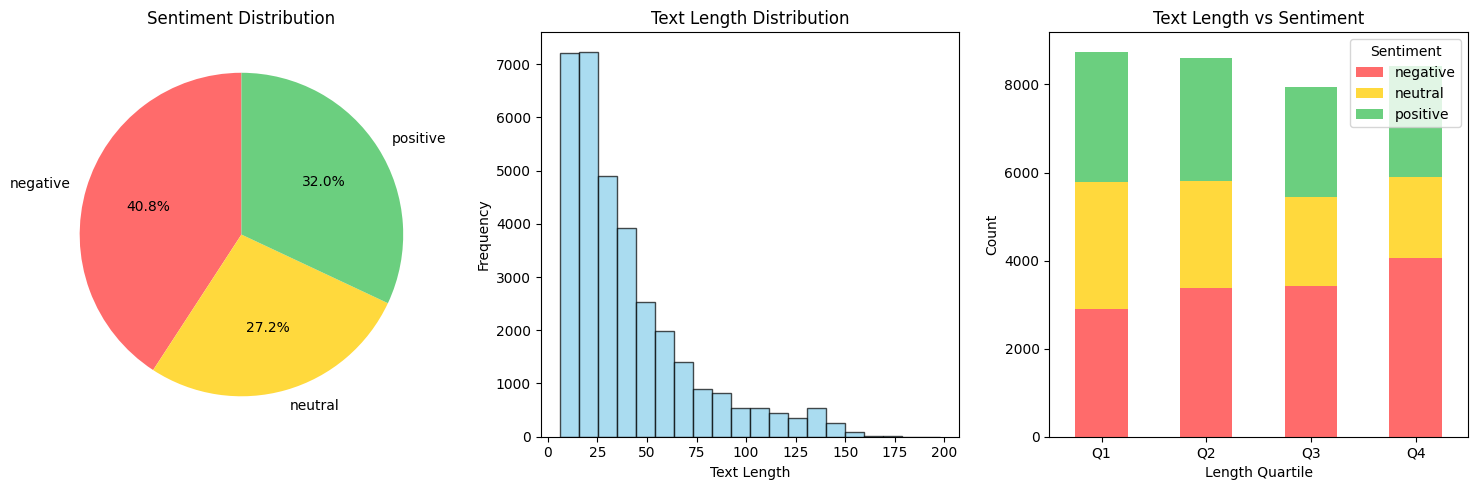


=== BUSINESS INSIGHTS & RECOMMENDATIONS ===
• QUALITY: 1029 mentions, 0.0% negative, 0.0% neutral
• SERVICE: 187 mentions, 0.0% negative, 0.0% neutral
• PRICE: 346 mentions, 0.0% negative, 0.0% neutral
• CONVENIENCE: 265 mentions, 0.0% negative, 0.0% neutral
• SPEED: 1212 mentions, 0.0% negative, 0.0% neutral
• ATMOSPHERE: 221 mentions, 0.0% negative, 0.0% neutral

===== Training cl-tohoku/bert-base-japanese-whole-word-masking =====


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Parameter 'function'=<function ABSALLMLoRAPipeline.prepare_datasets.<locals>.tokenize_function at 0x7a2c0fd3c180> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/33698 [00:00<?, ? examples/s]

Map:   0%|          | 0/8425 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.901500,0.898027
2,0.881900,0.876049


              precision    recall  f1-score   support

    negative       0.70      0.79      0.75      3438
     neutral       0.55      0.43      0.48      2293
    positive       0.69      0.70      0.70      2694

    accuracy                           0.67      8425
   macro avg       0.65      0.64      0.64      8425
weighted avg       0.66      0.67      0.66      8425


===== Training rinna/japanese-roberta-base =====


tokenizer_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/806k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/153 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at rinna/japanese-roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/33698 [00:00<?, ? examples/s]

Map:   0%|          | 0/8425 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.895200,0.874398
2,0.846700,0.842982


              precision    recall  f1-score   support

    negative       0.75      0.81      0.78      3438
     neutral       0.54      0.50      0.52      2293
    positive       0.75      0.71      0.73      2694

    accuracy                           0.70      8425
   macro avg       0.68      0.68      0.68      8425
weighted avg       0.69      0.70      0.69      8425


===== Training studio-ousia/luke-japanese-base-lite =====


tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/842k [00:00<?, ?B/s]

entity_vocab.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/33.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/873 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/536M [00:00<?, ?B/s]

Map:   0%|          | 0/33698 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

Map:   0%|          | 0/8425 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.775400,0.772411
2,0.754000,0.740451


              precision    recall  f1-score   support

    negative       0.79      0.83      0.81      3438
     neutral       0.63      0.53      0.58      2293
    positive       0.75      0.79      0.77      2694

    accuracy                           0.74      8425
   macro avg       0.72      0.72      0.72      8425
weighted avg       0.73      0.74      0.73      8425


===== Training xlm-roberta-base =====


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Map:   0%|          | 0/33698 [00:00<?, ? examples/s]

Map:   0%|          | 0/8425 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.912500,0.899655
2,0.861300,0.868412


              precision    recall  f1-score   support

    negative       0.73      0.79      0.76      3438
     neutral       0.55      0.49      0.52      2293
    positive       0.72      0.71      0.71      2694

    accuracy                           0.68      8425
   macro avg       0.67      0.66      0.66      8425
weighted avg       0.68      0.68      0.68      8425


===== Best model: studio-ousia/luke-japanese-base-lite (macro F1=0.7180) =====


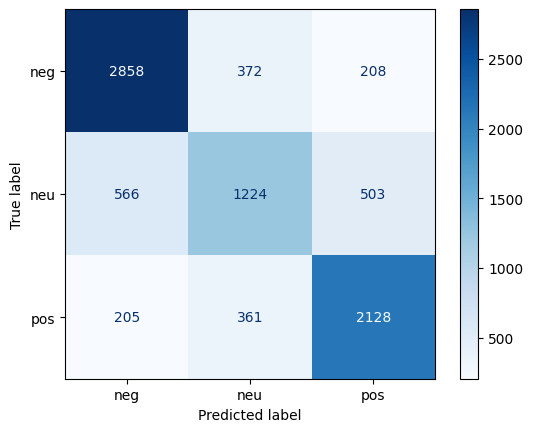

In [10]:
if __name__ == "__main__":
    pipeline = ABSALLMLoRAPipeline()
    result = pipeline.fit()
